In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun  4 20:16:21 2017

@author: JMJ136
"""
import os
import sys
sys.path.insert(1,'/home/jmj136/deep-learning/Utils')
import numpy as np
import ants
from keras.models import load_model
from HelperFunctions import BlockModel_reg
from tqdm import tqdm_notebook as tqdm

import GPUtil
if not 'DEVICE_ID' in locals():
    DEVICE_ID = GPUtil.getFirstAvailable()[0]
    print('Using GPU',DEVICE_ID)
os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_ID)

datapath = 'RegNIFTIs/subj{:03d}_{}.nii'
outputpath = 'OutputNIFTIs_xval/subj{:03d}_{}.nii'
subj_vec = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
model_filepath = 'MuMapModel_Xval_fold_{}_nodual.hdf5'.format(2)

eps = 1e-12
MS = 3 # multislice number

In [8]:
#%% Load model
RegModel = BlockModel_reg(np.zeros((1,3,256,256,4)),False,8)
RegModel.load_weights(model_filepath)

In [9]:
#%% Multislice maker for inputs
def ConvertToMultiSlice(array,MS=3):
    tshp = array.shape
    MSos = np.int((MS-1)/2) #MultiSlice Offset
    MSarray = np.zeros((tshp[0],MS,tshp[1],tshp[2],tshp[3]))
    for ss in range(MSos,tshp[0]-MSos):
        MSarray[ss,0,...] = array[ss-1]
        MSarray[ss,1,...] = array[ss]
        MSarray[ss,2,...] = array[ss+1]
    MSarray[0,0,...] = array[0]
    MSarray[0,1,...] = array[0]
    MSarray[0,2,...] = array[1]
    MSarray[-1,0,...] = array[-2]
    MSarray[-1,1,...] = array[-1]
    MSarray[-1,2,...] = array[-1]
    return MSarray

In [15]:
#%% Loop over all subjects
t = tqdm(range(len(subj_vec)))
t.write('Creating mu-Maps...')
for ii in t:
    #%% Inputs
    subj = subj_vec[ii]
    wims = np.rollaxis(ants.image_read(datapath.format(subj,'WATER')).numpy(),2,0)
    fims = np.rollaxis(ants.image_read(datapath.format(subj,'FAT')).numpy(),2,0)
    inims = np.rollaxis(ants.image_read(datapath.format(subj,'InPhase')).numpy(),2,0)
    outims = np.rollaxis(ants.image_read(datapath.format(subj,'OutPhase')).numpy(),2,0)
    good_inds = np.loadtxt('RegNIFTIs/subj{:03d}_indices.txt'.format(subj)).astype(np.int)
    for im in wims:
        im[im<0]=0
        im /= np.max(im)
    for im in fims:
        im[im<0]=0
        im /= np.max(im)
    for im in inims:
        im[im<0]=0
        im /= np.max(im)
    for im in outims:
        im[im<0]=0
        im /= (np.max(im)+eps)
    inputs = ConvertToMultiSlice(np.stack((wims,fims,inims,outims),axis=3),MS)
    
    #%% Make predictions on MR data
    reg_output = RegModel.predict(inputs,batch_size=8)
    # get regression output
    # and convert to units of mm
    reg_output[reg_output<0] = 0
    muMaps = reg_output[...,0]/50
    
    #%% Write output
    # convert to ants images
    nac_img = ants.image_read(datapath.format(subj,'NAC'))
    muMaps = np.rollaxis(muMaps,0,3)
    muMap_img = nac_img.new_image_like(muMaps)
    # write to nifti file
    ants.image_write(muMap_img,outputpath.format(subj,'regMap'))
    
print('Done!')


Processing subject 1


Processing subject 2


Processing subject 3


Processing subject 4


Processing subject 5


Processing subject 6


Processing subject 7


Processing subject 8


Processing subject 9


Processing subject 10


Processing subject 11


Processing subject 12


Processing subject 13


Processing subject 14


Processing subject 15


Processing subject 16


Processing subject 17


Processing subject 18



Done!


In [16]:
from VisTools import multi_slice_viewer0
%matplotlib notebook

<IPython.core.display.Javascript object>


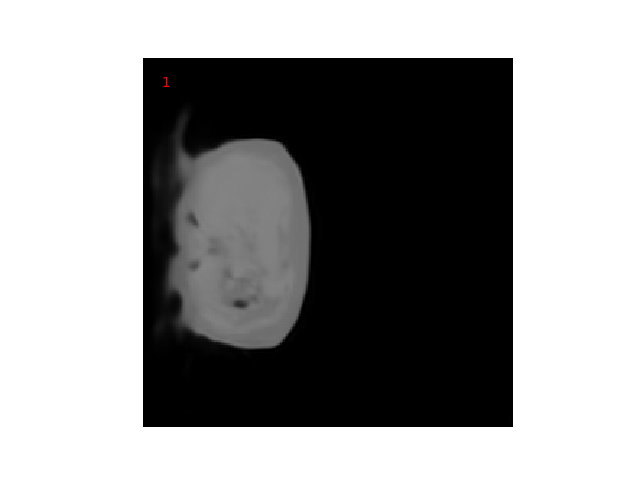

In [17]:
multi_slice_viewer0(reg_output[...,0])